# INFSCI 1040

## Homework 02 

## HANYU ZENG

In this assignment you will fit logistic regression models. You will work to understand how regularization impacts model results, and where regularization is applied within Python implementations of logistic regression. You will also assess logistic regression model performance via performance metrics discussed in lecture.  

You are allowed to add as many code cells and Markdown cells as you feel are needed.  

The cell below imports in libraries, classes, and methods which will be used throughout this assignment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.calibration import calibration_curve

In [2]:
from patsy import dmatrices

In [3]:
import statsmodels.formula.api as smf

## Problem 01 (15 points)
Read in the training set below. It consists of an input `x` and a binary response `y`. The binary response is encoded as 0 and 1 to represent the non-event and the event, respectively.

In [4]:
train_url = 'https://raw.githubusercontent.com/jyurko/INFSCI_1040_Spring_2020/master/hw_data/hw_02/training_set.csv'
train_df = pd.read_csv(train_url)

train_df.describe()

,x,y
count,50.000000,50.000000
mean,-0.107271,0.460000
std,1.028262,0.503457
min,-2.453090,0.000000
25%,-0.880415,0.000000
50%,-0.069746,0.000000
75%,0.625438,1.000000
max,2.125727,1.000000


In [6]:
df = train_df

In [15]:
X = df[['x']]
y = df[['y']]

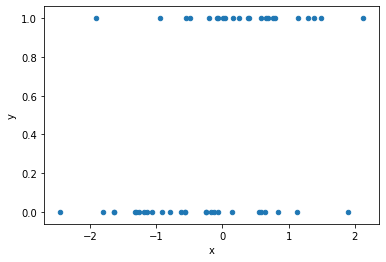

In [16]:
fig, ax = plt.subplots()
ax = df.plot.scatter(x = 'x', y = 'y', ax = ax)
plt.show()

In [23]:
mdl = smf.logit('y~x', data = df).fit()
mdl.summary()

Optimization terminated successfully.
         Current function value: 0.598495
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Apr 2020   Pseudo R-squ.:                  0.1325
Time:                        17:49:56   Log-Likelihood:                -29.925
converged:                       True   LL-Null:                       -34.497
Covariance Type:            nonrobust   LLR p-value:                  0.002494
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0947      0.312     -0.304      0.761      -0.706       0.516
x              0.9552      0.356      2.687      0.007       0.258       1.652
==============================================================================
"""

In [29]:
fig, ax = plt.subplot()
plt.clf()
plt.scatter(x,y,color='black')
ols = linear_model.Linear

<Figure size 432x288 with 0 Axes>

In [27]:
import seaborn as sns

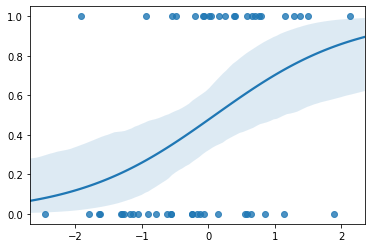

In [26]:
sns.regplot(x,y, data = df, logistic = True)

In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
x    50 non-null float64
y    50 non-null int64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes
None


We will fit a logistic regression model with a simple linear relationship between the input, $x$, and the linear predictor, $\eta$. The linear predictor is transformed into the probability of the event, $\mu$, via the logistic (inverse logit) function. The likelihood between the observed response, $y$, is a Bernoulli distribution.  

The model we wish to fit is shown below.  

$$ y_n \mid \mu_n \sim \mathrm{Bernoulli} \left( y_n \mid \mu_n \right) $$  
$$ \mu_n = \mathrm{logit}^{-1} \left(\eta_n \right) $$ 
$$ \eta_n = \beta_0 + \beta_1 x_n $$

### 1a)

Let's start out by fitting the logistic regression model with `statsmodels` using the formula interface. With the formula api imported in, as `smf`, you can use `smf.logit()` to fit the model.

In [27]:
#input the observed and input into the logit function and fit the data
mdl = smf.logit(formula = 'y~x',data = train_df).fit()
print(mdl.summary())

Optimization terminated successfully.
         Current function value: 0.598495
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Feb 2020   Pseudo R-squ.:                  0.1325
Time:                        22:34:34   Log-Likelihood:                -29.925
converged:                       True   LL-Null:                       -34.497
Covariance Type:            nonrobust   LLR p-value:                  0.002494
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0947      0.312     -0.304      0.761      -0.706       0.516
x              0.9552      0.

In [28]:
print('Intercept: -0.0947')
print('Slope: 0.9552')

Intercept: -0.0947
Slope: 0.9552


### 1b)
Let's use scikit-learn to fit the logistic regression model, instead of `statsmodels`. To do so, we must first create the response vector and design matrix. As discussed in lecture, we should neglect the intercept column when we create design matrices for scikit-learn models. Thus, we will instruct the formula interface in `dmatrices()` to drop the intercept.  

In [37]:
#creating the design matrices
yl,Xl = dmatrices("y~x-1",data = train_df, return_type = 'dataframe')

#sklearn output
mdl = LogisticRegression(solver = 'lbfgs').fit(Xl,np.ravel(yl))
#coefficient from sklearn model
cmdl = mdl.coef_
print(cmdl,'Which is smaller than the coefficient that we got from statsmodel')

[[0.85205114]] Which is smaller than the coefficient that we got from statsmodel


The scikit-learn implementation of logistic regression has been imported in already. Set the `solver` argument to `LogisticRegression()` equal to `'lbfgs'`. When we call the `.fit()` method associated with `LogisticRegression()` we will get a warning message if we pass in the response column vector directly from `dmatrices()`. The model will still fit, but to prevent the warning message you can use the `.ravel()` method associated with the response object.

### 1c)
The logistic regression method in scikit-learn, `LogisticRegression()`, does not actually find the maximum likelihood estimates (MLEs) on the parameters of the logistic regression model. By default it applies a ridge penalty to regularize the parameters!

In [40]:
#sklearn output wih the c value
#c == 0.01
mdl = LogisticRegression(C = 0.01, solver = 'lbfgs').fit(Xl,np.ravel(yl))
a = mdl.coef_
print(a,"the coefficient was previously 0.85")

[[0.09236139]] the coefficient was previously 0.85


### 1d)

In [41]:
#sklearn output with the c value
#c == 100
mdl = LogisticRegression(C = 100, solver = 'lbfgs').fit(Xl,np.ravel(yl))
b = mdl.coef_
print(b,"the value is closest to the calculated by statsmodel")

[[0.95400708]] the value is closest to the calculated by statsmodel


### 1e)
Alternatively, if we want classic logistic regression with maximum likelihood estimate coefficients we can completely turn off the regularization. To do so, we must set the `penalty` argument to `LogisticRegression()` equal to `'none'`. The default ridge penalty corresponds to `penalty='l2'`. We could also use `'l1'` for lasso or `'elasticnet'` which is a mixture of lasso and ridge. When changing the `penalty` argument in scikit-learn, you must also check to make sure the selected `solver` can handle that type of penalization. The `'lbfgs'` option we have used in this problem can handle ridge and no penalty. So, let's go ahead and fit the model with `penalty='none'`.  

In [42]:
mdl = LogisticRegression(penalty = 'none',solver = 'lbfgs').fit(Xl,np.ravel(yl))
c = mdl.coef_
print(c,"turning off the penalty value which resulted the same value that was previously calculated in statsmodel")

[[0.95521231]] turning off the penalty value which resulted the same value that was previously calculated in statsmodel


## Problem 02 (20 points)
In Problem 01, we focused on a simple linear relationship between the linear predictor $\eta$ and the input $x$. In this problem we will fit a cubic relationship and a 7th order polynomial. We will set the `penalty` term in the scikit-learn `LogisticRegression()` object to be `'none'` for both models, thus the logistic regression models will be fit by maximizing the likelihood.

### 2a) 
There should be exactly four unknown parameter for the cubic model

### 2b)
To fit the logistic regression model, we must first create the design matrix. Since we will use scikit-learn to fit the model, we will **not** include the intercept column in the design matrix.

In [43]:
#create a new dataframe so we can cube X
cu = train_df[['x','y']].copy()
#cube the x value to create the cubic 
cu = cu.rename(columns = {'x':'x3','y':'y'})
cu['x3']=np.power(cu['x3'],3)
########################################
#create a new dataframe so we can square x
sq = train_df[['x','y']].copy()
sq = sq.rename(columns = {'x':'x2','y':'y'})
#square the x value 
sq['x2'] = np.power(sq['x2'],2)

In [184]:
#Since there is going to be four unknown parameter we need a new dataframe
n_df = train_df[['x','y']].copy()
#adding the cubic and square into the new dataframe
n_df['x2'] = sq['x2']
n_df['x3'] = cu['x3'] 
#n_df.head()

In [45]:
#design matrix for the cubic function
yc,xc = dmatrices("y~x+x2+x3-1", data = n_df, return_type = 'dataframe')

In [46]:
xc.head()

,x,x2,x3
0,1.288354,1.659856,2.138481
1,1.149273,1.320827,1.517991
2,0.654326,0.428143,0.280145
3,0.695236,0.483353,0.336044
4,-1.137775,1.294533,-1.472888


### 2c)
You should continue to be cautious with the dimensions of the response vector.

In [47]:
cmdl = LogisticRegression(solver = 'lbfgs').fit(xc,np.ravel(y))
cmdl.coef_

array([[ 1.01335728, -0.17465769, -0.08286256]])

### 2d)

$\mu$ = $\beta_0$ + $\beta_1x$ + $\beta_2x^2$ + $\beta_3x^3$ + $\beta_4x^4$ + $\beta_5x^5$ + $\beta_6x^6$ + $\beta_7x^7$

There would be seven columns for the seventh polynomial function

### 2e)

In [49]:
#create a new dataframe for x^7
sv = train_df[['x','y']].copy()
#x^7
sv = sv.rename(columns = {'x':'x7','y':'y'})
sv['x7']=np.power(sv['x7'],7)
########################################
#create a new dataframe for x^6
sx = train_df[['x','y']].copy()
#x^6
sx = sx.rename(columns = {'x':'x6','y':'y'})
sx['x6']=np.power(sx['x6'],6)
########################################
#create a new dataframe so we can x^5
fi = train_df[['x','y']].copy()
#x^5
fi = fi.rename(columns = {'x':'x5','y':'y'})
fi['x5']=np.power(fi['x5'],5)
########################################
#create a new dataframe for x^4
fo = train_df[['x','y']].copy()
fo = fo.rename(columns = {'x':'x4','y':'y'})
#x^4
fo['x4'] = np.power(fo['x4'],4)

In [50]:
#adding all the polynomial to the dataframe
n_df['x4'] = fo['x4'] 
n_df['x5'] = fi['x5']
n_df['x6'] = sx['x6']
n_df['x7'] = sv['x7']

In [199]:
n_df.head()

,x,y,x2,x3,x4,x5,x6,x7
0,1.288354,1,1.659856,2.138481,0.080838,-0.043104,0.022984,-0.012255
1,1.149273,1,1.320827,1.517991,0.984842,-0.981088,0.977349,-0.973624
2,0.654326,1,0.428143,0.280145,2.529813,-3.190513,4.023765,-5.074634
3,0.695236,1,0.483353,0.336044,0.117762,0.068985,0.040412,0.023673
4,-1.137775,0,1.294533,-1.472888,0.118295,0.069376,0.040686,0.023861


In [53]:
#design matrix for the seventh polynomial
ys,xs = dmatrices("y~x+x2+x3+x4+x5+x6+x7-1", data = n_df, return_type = 'dataframe')
#show the amount of column we have excluding the intercept
xs.head()

,x,x2,x3,x4,x5,x6,x7
0,1.288354,1.659856,2.138481,2.755121,3.549570,4.573103,5.891775
1,1.149273,1.320827,1.517991,1.744585,2.005004,2.304296,2.648264
2,0.654326,0.428143,0.280145,0.183306,0.119942,0.078481,0.051352
3,0.695236,0.483353,0.336044,0.233630,0.162428,0.112926,0.078510
4,-1.137775,1.294533,-1.472888,1.675815,-1.906701,2.169398,-2.468287


### 2f)
Please note again that the `.ravel()` method is applied to the `dmatrices()` response vector should be used in the call to the `.fit()` method. Please raise, the maximum number of iterations, `max_iter`. Set it to 1001.  

In [83]:
#building logistic regression for seventh polynomial
smdl = LogisticRegression(solver = 'lbfgs',max_iter = 1001).fit(xs,np.ravel(ys))
smdl.coef_

array([[ 0.93242619, -0.45145822,  0.78735425, -0.0593608 , -0.57459551,
         0.04188569,  0.08292674]])

### 2g)
Setting random seeds would not matter as the predicted values are observation of events and non events and also the differernt results should not be a problem because it does not effect the final result.

## Problem 03 (25 points)
Let's now compare the 3 different logistic regression models we have fit to the training data. The following comparisons will be made just on the training set.

### 3a)
It's quite straight forward to calculate the accuracy for each model. You can use the `.score()` method associated with each model object by providing the input design matrix and the observed output column vector.

In [56]:
#linear model score
mdl.score(Xl,np.ravel(yl))

0.68

In [57]:
#cubic model score
cmdl.score(xc,np.ravel(yc))

0.72

In [58]:
#seventh nomial model score
smdl.score(xs,np.ravel(ys))

0.72

The highest accuracy from all the models seems to be both cubic and seventh nomial model where both score 0.72, where as the linear model had a lower accurac score.

### 3b)
We need to predict the training set and store the predicted probability of the event in order to calculate the ROC and calibration curves. With scikit-learn the class probabilities are returned with the `.predict_proba()` method. You can check which class corresponds to which column in the output from `.predict_proba()` by using the `.classes_` attribute associated with the model object.

In [74]:
#linear model 
linpred = mdl.predict_proba(Xl)
linpred.shape
#print(linpred)

(50, 2)

In [75]:
#cubic model
cubpred = cmdl.predict_proba(xc)
cubpred.shape
#print(cubpred)

(50, 2)

In [76]:
#seventh polynomial
svpred = smdl.predict_proba(xs)
svpred.shape
#print(svpred)

(50, 2)

All the model seems to return the same amount of column of (50,2), the two column indicated that probability for the target (0 and 1) in array form. The number of probabilities for each row is equal to the number of categories in target variables.

### 3c)
You can use the `metrics.roc_curve()` function to calculate the True Positive Rate (TPR) and False Positive Rate (FPR). We just have to supply the observed class, and the predicted probabilities for the "Positive" class. Be careful about assigning which variable to the arguments to `metrics.roc_curve()`.

In [87]:
#linear model
lfpr, ltpr, lthresholds = metrics.roc_curve(yl['y'].to_numpy(),linpred[:,1])
#print the result
lfpr,ltpr,lthresholds

(array([0.        , 0.        , 0.03703704, 0.03703704, 0.11111111,
        0.11111111, 0.14814815, 0.14814815, 0.22222222, 0.22222222,
        0.25925926, 0.25925926, 0.2962963 , 0.2962963 , 0.37037037,
        0.37037037, 0.44444444, 0.44444444, 0.62962963, 0.62962963,
        0.96296296, 0.96296296, 1.        ]),
 array([0.        , 0.04347826, 0.04347826, 0.2173913 , 0.2173913 ,
        0.39130435, 0.39130435, 0.43478261, 0.43478261, 0.60869565,
        0.60869565, 0.69565217, 0.69565217, 0.7826087 , 0.7826087 ,
        0.82608696, 0.82608696, 0.91304348, 0.91304348, 0.95652174,
        0.95652174, 1.        , 1.        ]),
 array([1.87389628, 0.87389628, 0.8468467 , 0.73167462, 0.67118864,
        0.62956636, 0.6264736 , 0.61294213, 0.60710887, 0.51485025,
        0.51129049, 0.47841893, 0.46093027, 0.45863142, 0.43726821,
        0.42911554, 0.41706804, 0.35046942, 0.27598473, 0.2704326 ,
        0.14057741, 0.1280101 , 0.08032901]))

### 3d)

In [90]:
#cubic model 
cfpr, ctpr, cthresholds = metrics.roc_curve(yc['y'].to_numpy(),cubpred[:,1])
#print the result
cfpr, ctpr, cthresholds 

(array([0.        , 0.        , 0.        , 0.11111111, 0.11111111,
        0.14814815, 0.14814815, 0.22222222, 0.22222222, 0.25925926,
        0.25925926, 0.2962963 , 0.2962963 , 0.37037037, 0.37037037,
        0.44444444, 0.44444444, 0.62962963, 0.62962963, 0.96296296,
        0.96296296, 1.        ]),
 array([0.        , 0.04347826, 0.17391304, 0.17391304, 0.39130435,
        0.39130435, 0.43478261, 0.43478261, 0.60869565, 0.60869565,
        0.69565217, 0.69565217, 0.7826087 , 0.7826087 , 0.82608696,
        0.82608696, 0.91304348, 0.91304348, 0.95652174, 0.95652174,
        1.        , 1.        ]),
 array([1.7090527 , 0.7090527 , 0.70068641, 0.67362182, 0.64736952,
        0.6452055 , 0.6354115 , 0.63102922, 0.55007932, 0.54655588,
        0.51279698, 0.4940018 , 0.49149163, 0.4677585 , 0.45852134,
        0.44470774, 0.36578121, 0.27636115, 0.26983124, 0.13456909,
        0.12427902, 0.09353137]))

In [91]:
#seventh polynomial
sfpr, stpr, sthresholds = metrics.roc_curve(ys['y'].to_numpy(),svpred[:,1])
#print the result
sfpr, stpr, sthresholds

(array([0.        , 0.        , 0.03703704, 0.03703704, 0.07407407,
        0.07407407, 0.11111111, 0.11111111, 0.18518519, 0.18518519,
        0.22222222, 0.22222222, 0.25925926, 0.25925926, 0.37037037,
        0.37037037, 0.44444444, 0.44444444, 0.66666667, 0.66666667,
        1.        ]),
 array([0.        , 0.04347826, 0.04347826, 0.08695652, 0.08695652,
        0.30434783, 0.30434783, 0.34782609, 0.34782609, 0.60869565,
        0.60869565, 0.69565217, 0.69565217, 0.7826087 , 0.7826087 ,
        0.82608696, 0.82608696, 0.95652174, 0.95652174, 1.        ,
        1.        ]),
 array([1.83548889, 0.83548889, 0.7072334 , 0.70555117, 0.69994798,
        0.66995988, 0.66738044, 0.65581994, 0.65074156, 0.57070395,
        0.56760569, 0.53765757, 0.52006208, 0.51762665, 0.49330813,
        0.48311121, 0.46698018, 0.35128548, 0.20177124, 0.19220698,
        0.05770169]))

### 3e)

In [93]:
#import matplotlib to graph the roc curve
import matplotlib.pyplot as plt

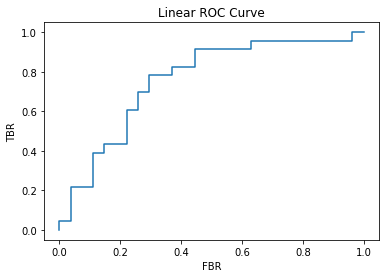

In [117]:
#linear roc curve
plt.title("Linear ROC Curve")
plt.xlabel("FBR")
plt.ylabel("TBR")
plt.plot(lfpr,ltpr)

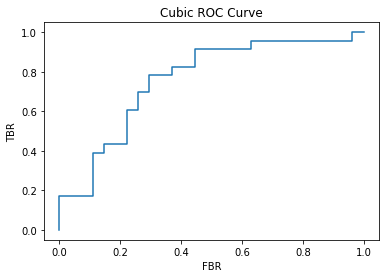

In [118]:
#cubic roc curve
plt.title("Cubic ROC Curve")
plt.xlabel("FBR")
plt.ylabel("TBR")
plt.plot(cfpr,ctpr)

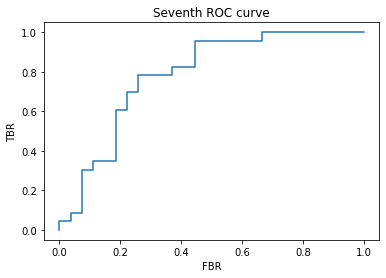

In [119]:
#seventh polynomial roc curve
plt.title("Seventh ROC curve")
plt.xlabel("FBR")
plt.ylabel("TBR")
plt.plot(sfpr,stpr)

### 3f)
The Area Under the Curve (AUC) values can be calculated with the `metrics.roc_auc_score()` function. Be careful about the ordering.  

In [104]:
#linear model auc curve
lin_auc = metrics.roc_auc_score(yl['y'].to_numpy(),linpred[:,1])
#cubic model auc curve
cub_auc = metrics.roc_auc_score(yc['y'].to_numpy(),cubpred[:,1])
#seventh polynomial model auc curve
sev_auc = metrics.roc_auc_score(ys['y'].to_numpy(),svpred[:,1])

In [123]:
#display the auc score
print("AUC_SCORE for linar model:", lin_auc)
print("AUC_SCORE for cubic model:", cub_auc)
print("AUC_SCORE for seven model:", sev_auc)
print("It seems that the seventh polynomial model has the highest auc score")

AUC_SCORE for linar model: 0.7568438003220611
AUC_SCORE for cubic model: 0.7584541062801932
AUC_SCORE for seven model: 0.784219001610306
It seems that the seventh polynomial model has the highest auc score


### 3g)
The information necessary to create the calibration is determined by using the `calibration_curve()` function, which has been imported in for you.

In [129]:
#calibration curve for linear model
lin_cal = calibration_curve(yl['y'].to_numpy(),linpred[:,1], n_bins = 5)
#calibration curve for cubic model
cub_cal = calibration_curve(yc['y'].to_numpy(),cubpred[:,1], n_bins = 5)
#calibration curve for seventh polynomial model
sev_cal = calibration_curve(ys['y'].to_numpy(),svpred[:,1], n_bins = 5)

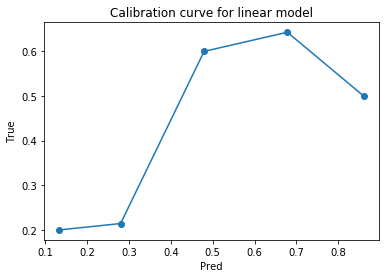

In [131]:
#calibration curve for linear model
plt.title("Calibration curve for linear model")
plt.xlabel("Pred")
plt.ylabel("True")
plt.plot(lin_cal[1],lin_cal[0], linestyle = '-', marker = 'o')

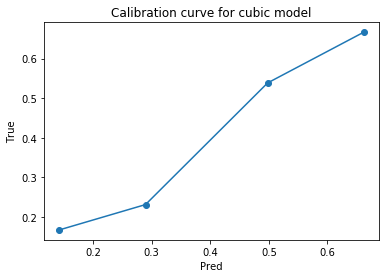

In [132]:
#calibration curve for linear model
plt.title("Calibration curve for cubic model")
plt.xlabel("Pred")
plt.ylabel("True")
plt.plot(cub_cal[1], cub_cal[0], linestyle = '-', marker = 'o')

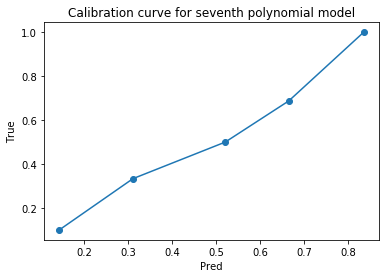

In [133]:
#calibration curve for seventh polynomial model
plt.title("Calibration curve for seventh polynomial model")
plt.xlabel("Pred")
plt.ylabel("True")
plt.plot(sev_cal[1],sev_cal[0], linestyle = '-', marker = 'o')

### 3h)
The Brier score can be calculated with the `metrics.brier_score_loss()` function. We supply the observed output and the predicted probability for the "Positive" class.

In [137]:
#linear brier score
lin_bsc = metrics.brier_score_loss(yl['y'].to_numpy(),linpred[:,1])
#cubic brier score
cub_bsc = metrics.brier_score_loss(yc['y'].to_numpy(),cubpred[:,1])
#seventh brier score
sev_bsc = metrics.brier_score_loss(ys['y'].to_numpy(),svpred[:,1])

In [141]:
#Result for brier score
print("Linear Brier score: ", lin_bsc)
print("Cubic Brier Score: ", cub_bsc)
print("Seventh Brier score: ", sev_bsc)
print("The seventh polynomial has the lowest brier score that shows ROC and AUC score which shows that has the best model")

Linear Brier score:  0.20443546706760252
Cubic Brier Score:  0.20107151691822728
Seventh Brier score:  0.18920162307490002
The seventh polynomial has the lowest brier score that shows ROC and AUC score which shows that has the best model


## Problem 04 (20 points)
The three models were compared multiple ways in Problem 03, but only based on the training set. In this problem we will repeat the actions in Problem 03, but using a new held-out data set. That data set is loaded in the cell below. The test set has the format as the training set, consisting of a single input `x` and binary outcome `y`.

In [142]:
test_url = 'https://raw.githubusercontent.com/jyurko/INFSCI_1040_Spring_2020/master/hw_data/hw_02/test_set.csv'
test_df = pd.read_csv(test_url)

print( test_df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
x    50 non-null float64
y    50 non-null int64
dtypes: float64(1), int64(1)
memory usage: 928.0 bytes
None


### 4a)
Create the necessary test design matrices using the `test_df` data set.

In [180]:
#create a new dataframe so we can cube X
tri = test_df[['x','y']].copy()
tri = tri.rename(columns = {'x':'x3','y':'y'})
#cube the value
trip['x3']=np.power(cbdf['x3'],3)
########################################
#create a new dataframe so we can square x
doub = test_df[['x','y']].copy()
doub = doub.rename(columns = {'x':'x2','y':'y'})
#square the x value 
doub['x2'] = np.power(sqr['x2'],2)

In [186]:
#Since there is going to be four unknown parameter we need a new dataframe
trip = test_df[['x','y']].copy()
#adding the cubic and square into the new dataframe
trip['x2'] = sq['x2']
trip['x3'] = cu['x3'] 
#n_df.head()

In [191]:
#create a new dataframe for x^7
sv = test_df[['x','y']].copy()
#x^7
sv = sv.rename(columns = {'x':'x7','y':'y'})
sv['x7']=np.power(sv['x7'],7)
########################################
#create a new dataframe for x^6
sx = test_df[['x','y']].copy()
#x^6
sx = sx.rename(columns = {'x':'x6','y':'y'})
sx['x6']=np.power(sx['x6'],6)
########################################
#create a new dataframe so we can x^5
fi = test_df[['x','y']].copy()
#x^5
fi = fi.rename(columns = {'x':'x5','y':'y'})
fi['x5']=np.power(fi['x5'],5)
########################################
#create a new dataframe for x^4
fo = test_df[['x','y']].copy()
fo = fo.rename(columns = {'x':'x4','y':'y'})
#x^4
fo['x4'] = np.power(fo['x4'],4)

In [200]:
#adding all the polynomial to the dataframe
svn = trip[['x','y','x2','x3']].copy()
svn['x4'] = fo['x4'] 
svn['x5'] = fi['x5']
svn['x6'] = sx['x6']
svn['x7'] = sv['x7']

In [210]:
#design marix for linear
ylin, xlin = dmatrices('y~x-1', data = test_df, return_type = 'dataframe')

In [211]:
#design matrix for cubic 
ytrip, xtrip = dmatrices('y~x+x2+x3-1', data = trip, return_type = 'dataframe')

In [212]:
#design matrix for seven
ysvn, xsvn = dmatrices('y~x+x2+x3+x4+x5+x6+x7-1', data = svn, return_type = 'dataframe')

### 4b)

In [217]:
#logisitc regression for line model
linlog = LogisticRegression(solver = 'lbfgs')
linlog.fit(xlin, np.ravel(ylin))
#logisitc regression for cube
cublog = LogisticRegression(solver = 'lbfgs')
cublog.fit(xtrip, np.ravel(ytrip))
#logisitc regression for sev
sevlog = LogisticRegression(solver = 'lbfgs')
sevlog.fit(xsvn, np.ravel(ysvn))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [219]:
linscore = linlog.score(xlin, np.ravel(ylin))
cubscore = cublog.score(xtrip, np.ravel(ytrip))
sevscore = sevlog.score(xsvn, np.ravel(ysvn))

In [221]:
print("linear: ", linscore)
print("cubic: ", cubscore)
print("seven: ", sevscore)

print("the best result is model seven as it scored 0.78")

linear:  0.7
cubic:  0.74
seven:  0.78
the best result is model seven as it scored 0.78


### 4c)

In [224]:
#linear
ofpr, otpr, othreshold = metrics.roc_curve(ylin['y'].to_numpy(),linlog.predict_proba(xlin)[:,1])
ofpr, otpr, othreshold

(array([0.        , 0.        , 0.        , 0.03703704, 0.03703704,
        0.07407407, 0.07407407, 0.11111111, 0.11111111, 0.14814815,
        0.14814815, 0.18518519, 0.18518519, 0.25925926, 0.25925926,
        0.2962963 , 0.2962963 , 0.33333333, 0.33333333, 0.48148148,
        0.48148148, 0.55555556, 0.55555556, 0.85185185, 0.85185185,
        1.        ]),
 array([0.        , 0.04347826, 0.17391304, 0.17391304, 0.34782609,
        0.34782609, 0.43478261, 0.43478261, 0.47826087, 0.47826087,
        0.52173913, 0.52173913, 0.60869565, 0.60869565, 0.73913043,
        0.73913043, 0.7826087 , 0.7826087 , 0.82608696, 0.82608696,
        0.91304348, 0.91304348, 0.95652174, 0.95652174, 1.        ,
        1.        ]),
 array([1.91115062, 0.91115062, 0.87969086, 0.78584139, 0.68533544,
        0.67243585, 0.64692077, 0.62904319, 0.61392361, 0.59728233,
        0.59134104, 0.59115796, 0.5521481 , 0.53158995, 0.4627047 ,
        0.45632599, 0.45366694, 0.44358527, 0.44016901, 0.3789263 ,
    

In [232]:
#Cubic
tfpr, ttpr, tthreshold = metrics.roc_curve(ytrip['y'].to_numpy(),cublog.predict_proba(xtrip)[:,1])
tfpr, ttpr, tthreshold

(array([0.        , 0.        , 0.        , 0.03703704, 0.03703704,
        0.07407407, 0.07407407, 0.11111111, 0.11111111, 0.18518519,
        0.18518519, 0.22222222, 0.22222222, 0.33333333, 0.33333333,
        0.40740741, 0.40740741, 0.48148148, 0.48148148, 0.51851852,
        0.51851852, 0.85185185, 0.85185185, 1.        ]),
 array([0.        , 0.04347826, 0.13043478, 0.13043478, 0.39130435,
        0.39130435, 0.47826087, 0.47826087, 0.60869565, 0.60869565,
        0.69565217, 0.69565217, 0.7826087 , 0.7826087 , 0.82608696,
        0.82608696, 0.86956522, 0.86956522, 0.91304348, 0.91304348,
        0.95652174, 0.95652174, 1.        , 1.        ]),
 array([1.94046695, 0.94046695, 0.86367387, 0.82836749, 0.69271797,
        0.69227118, 0.65576664, 0.62814635, 0.57362085, 0.52168484,
        0.51072577, 0.5032931 , 0.46935288, 0.4536038 , 0.44848118,
        0.44524422, 0.41179546, 0.3779981 , 0.34459411, 0.31255065,
        0.29753053, 0.15593196, 0.12744161, 0.01882487]))

In [233]:
#seventh
vfpr, vtpr, vthreshold = metrics.roc_curve(ysvn['y'].to_numpy(),sevlog.predict_proba(xsvn)[:,1])
vfpr, vtpr, vthreshold

(array([0.        , 0.        , 0.        , 0.03703704, 0.03703704,
        0.07407407, 0.07407407, 0.11111111, 0.11111111, 0.14814815,
        0.14814815, 0.2962963 , 0.2962963 , 0.33333333, 0.33333333,
        0.40740741, 0.40740741, 0.85185185, 0.85185185, 1.        ]),
 array([0.        , 0.04347826, 0.17391304, 0.17391304, 0.39130435,
        0.39130435, 0.43478261, 0.43478261, 0.47826087, 0.47826087,
        0.73913043, 0.73913043, 0.7826087 , 0.7826087 , 0.82608696,
        0.82608696, 0.95652174, 0.95652174, 1.        , 1.        ]),
 array([1.99999971e+00, 9.99999714e-01, 9.85671635e-01, 7.72294808e-01,
        6.72735393e-01, 6.71791988e-01, 6.46302000e-01, 6.25562340e-01,
        6.18127505e-01, 5.82940677e-01, 4.88536680e-01, 4.63892940e-01,
        4.61092657e-01, 4.42931675e-01, 4.30529038e-01, 4.13859894e-01,
        3.39655042e-01, 1.78129279e-01, 1.51297831e-01, 9.06260254e-23]))

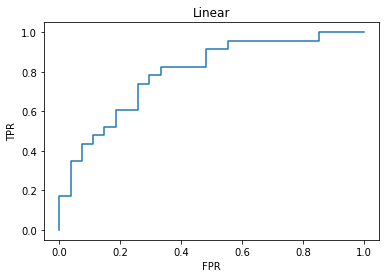

In [234]:
#roc linear
plt.title("Linear")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(ofpr, otpr)

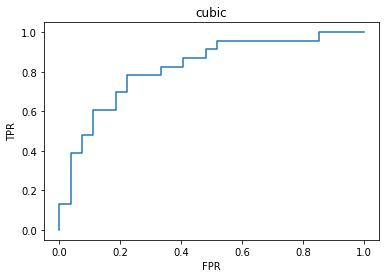

In [235]:
#cubic roc
plt.title("cubic")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(tfpr, ttpr)

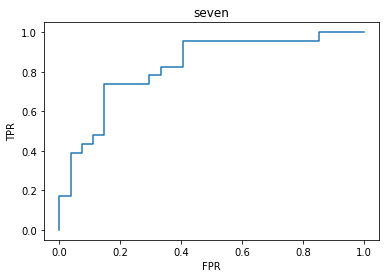

In [237]:
#seventh polynomial
plt.title("seven")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(vfpr, vtpr)

### 4d)

In [239]:
clinf = calibration_curve(ylin['y'].to_numpy(),linlog.predict_proba(xlin)[:,1])
ccubf = calibration_curve(ytrip['y'].to_numpy(),cublog.predict_proba(xtrip)[:,1])
csevf = calibration_curve(ysvn['y'].to_numpy(),sevlog.predict_proba(xsvn)[:,1])

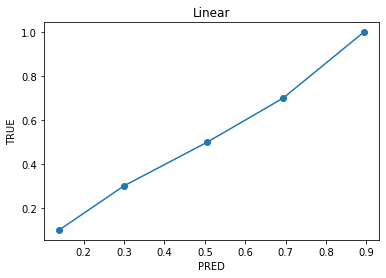

In [240]:
# Model 1 
plt.title("Linear")
plt.xlabel("PRED")
plt.ylabel("TRUE")
plt.plot( clinf[1],clinf[0], linestyle='-', marker='o')

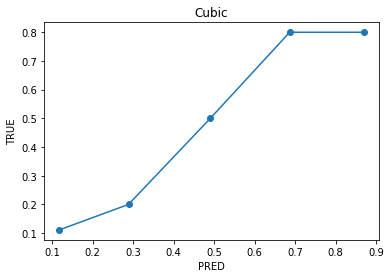

In [241]:
# Model 2 
plt.title("Cubic")
plt.xlabel("PRED")
plt.ylabel("TRUE")
plt.plot( ccubf[1],ccubf[0], linestyle='-', marker='o')

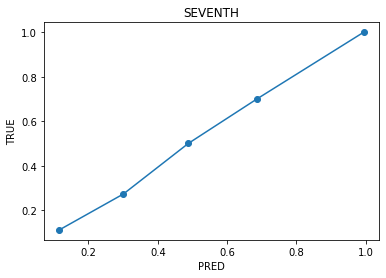

In [242]:
# Model 3 
plt.title("SEVENTH")
plt.xlabel("PRED")
plt.ylabel("TRUE")
plt.plot( csevf[1],csevf[0], linestyle='-', marker='o')

### 4e)

In [246]:
auclinf = metrics.roc_auc_score(ylin['y'].to_numpy(),linlog.predict_proba(xlin)[:,1])
auccubf = metrics.roc_auc_score(ytrip['y'].to_numpy(),cublog.predict_proba(xtrip)[:,1])
aucsvnf = metrics.roc_auc_score(ysvn['y'].to_numpy(),sevlog.predict_proba(xsvn)[:,1])

print("AUC Score for Linear", auclinf)
print("AUC Score for Cubic", auccubf)
print("AUC Score for Seventh", aucsvnf)

AUC Score for Linear 0.7954911433172303
AUC Score for Cubic 0.821256038647343
AUC Score for Seventh 0.8276972624798712


In [249]:
brlinf = metrics.brier_score_loss(ylin['y'].to_numpy(),linlog.predict_proba(xlin)[:,1])
brcubf = metrics.brier_score_loss(ytrip['y'].to_numpy(),cublog.predict_proba(xtrip)[:,1])
brsvnf = metrics.brier_score_loss(ysvn['y'].to_numpy(),sevlog.predict_proba(xsvn)[:,1])

print("Linear Brier score: ", brlinf)
print("Cubic Brier score: ", brcubf)
print("Seventh Brier score: ", brsvnf)


Linear Brier score:  0.18354229662076618
Cubic Brier score:  0.17591301193606032
Seventh Brier score:  0.1717906726537642


Linear has the best brier score where as the Seventh poly has the best auc score

## Problem 05 (20 points)
You will now use k-fold cross-validation to compare the performance of the 3 models. You will only use the original training set, and will use 5-fold cross-validation. You can use the `cross_val_score()` function to manage the resampling procedure and calculation of the performance metrics. The models will be compared based on their AUC values by setting the `scoring` argument equal to `roc_auc`.  

In [250]:
kfold = KFold(n_splits = 5)
kmdl = LogisticRegression(C= 1, max_iter = 1001)

In [258]:
#linear kfold
kmdl.fit(xlin, np.ravel(ylin))
crval = cross_val_score(kmdl,xlin,np.ravel(ylin), cv = kfold, scoring = 'roc_auc')

C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

In [259]:
#cub kfold
kmdl.fit(xcub, np.ravel(ycub))
cr2val = cross_val_score(kmdl,xcub,np.ravel(ycub), cv = kfold, scoring = 'roc_auc')

C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

In [260]:
#svn kfold
#linear kfold
kmdl.fit(xsvn, np.ravel(ysvn))
cr3val = cross_val_score(kmdl,xsvn,np.ravel(ysvn), cv = kfold, scoring = 'roc_auc')

C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\qma67\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

In [263]:
print("Linear: ",crval )
print("Cubic: ",cr2val)
print("Seventh: ",cr3val)

Linear:  [0.66666667 0.5        0.875      0.95238095 0.9047619 ]
Cubic:  [0.66666667 0.5        0.875      0.95238095 0.9047619 ]
Seventh:  [0.57142857 0.625      0.91666667 0.95238095 0.76190476]


In [264]:
crval = pd.DataFrame([crval,cr2val,cr3val])

In [266]:
crval.head()

,0,1,2,3,4
0,0.666667,0.500,0.875000,0.952381,0.904762
1,0.666667,0.500,0.875000,0.952381,0.904762
2,0.571429,0.625,0.916667,0.952381,0.761905


In [270]:
print(-crval.apply(np.mean, axis=1))

0   -0.779762
1   -0.779762
2   -0.765476
dtype: float64


Seems model 1 and 2 have the same score which are the lowest which means that those two have the best performance.